In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import *
import os

In [2]:
rast = pd.read_csv('/home/m/Dropbox/Clostridium_paper/data_analysis/Ref_Seq_Category_annotation_table.csv') ### THIS IS OLD ANNOTATION ###

In [3]:
ribodf = pd.read_csv('./data_analysis/results_12_21_2016/table_counts_RIBOseq_new_annotation.txt')
rnadf = pd.read_csv('./data_analysis/results_12_21_2016/table_counts_RNAseq_new_annotation.txt')
df=pd.merge(ribodf, rnadf)

## Making gene_df that contains gene lengths for rpkm caluclation

In [18]:
infile = SeqIO.read('/home/m/genome_files/REF-seq_CLJU.gbk','gb')
genes =[]
name = []
product = []
func = []
strand = []
start = []
stop = []
aaseq = []
cds_seq = []
old_tag=[]

    #genome_seq_df = pd.DataFrame({'sequence':list(str(infile.seq))},index=range(1,len(str(infile.seq))+1))
for feature in infile.features:
    if feature.type == 'CDS' or feature.type == 'rRNA' or feature.type == 'tRNA':  #Only cares for coding sequences which are not pseudogenes
        genes.append(feature.qualifiers['locus_tag'][0])
        try: old_tag.append(feature.qualifiers['old_locus_tag'][0])
        except: old_tag.append('')
        try: name.append(feature.qualifiers['gene'][0])
        except: name.append('')
        product.append(feature.qualifiers['product'][0])
        cds_seq.append(feature.location.extract(infile.seq).tostring())
        if 'function' in feature.qualifiers:                       #not all genes have known functions
            func.append(feature.qualifiers['function'][0])
        else:
            func.append("N/A")
        try:
            aaseq.append(feature.qualifiers['translation'][0])
        except:
            aaseq.append("N/A")
        if feature.strand == 1:
            strand.append("plus")
            start.append(feature.location.start.real+1)
            stop.append(feature.location.end.real)
        elif feature.strand == -1:
            strand.append("minus")
            start.append(feature.location.start.real+1)
            stop.append(feature.location.end.real)
gene_df = pd.DataFrame({"gene_id": genes, 'old_gene_id':old_tag, "name": name, "product": product, "function": func, "strand": strand, "start": start, "stop": stop, "cds_seq":cds_seq,"aaseq": aaseq},
                          columns = ["gene_id", "old_gene_id","name", "function", "product", "strand", "start", "stop", "cds_seq","aaseq"])

In [19]:
gene_df=gene_df[['gene_id', 'old_gene_id','start',u'stop','product' ]]
df = pd.merge(df,gene_df)
df['gene_length']=df.stop-df.start + 1

## RPKM normalization and averaging of duplicates
- Ribo-seq duplicates were individually RPKM-normalize and the average gene translation was calculated by summing and dividing by two. 
- RNA-seq duplicates were individually FPKM-normalized and the average gene transcirption was calculated by summing and dividing by two. 

RPKM =  10^6 * C * 10^3 / L*M    where,

C = number of  mappable reads per each feature (in our case per gene)

L = number of the length of the feature (lenght of the gene) in kb (10^3)

M = Total number of mappable reads per sample in Millions

In [20]:
df['ribo_rpkm_co1']=(df.co1 * 1000000000)/(df.co1.sum()*df.gene_length)
df['ribo_rpkm_co2']=(df.co2 * 1000000000)/(df.co2.sum()*df.gene_length)
df['ribo_rpkm_hf1']=(df.hf1 * 1000000000)/(df.hf1.sum()*df.gene_length)
df['ribo_rpkm_hf2']=(df.hf2 * 1000000000)/(df.hf2.sum()*df.gene_length)
df['ribo_rpkm_h2c1']=(df['h2co2.1'] * 1000000000)/(df['h2co2.1'].sum()*df.gene_length)
df['ribo_rpkm_h2c2']=(df['h2co2.2'] * 1000000000)/(df['h2co2.2'].sum()*df.gene_length)
df['rna_rpkm_co1']=(df.co1rn *1000000000)/(df.co1rn.sum()*df.gene_length)
df['rna_rpkm_co2']=(df.co2rn *1000000000)/(df.co2rn.sum()*df.gene_length)
df['rna_rpkm_hf1']=(df.hf1rn *1000000000)/(df.hf1rn.sum()*df.gene_length)
df['rna_rpkm_hf2']=(df.hf2rn *1000000000)/(df.hf2rn.sum()*df.gene_length)
df['rna_rpkm_h2c1']=(df['h2co2.1rn'] *1000000000)/(df['h2co2.1rn'].sum()*df.gene_length)
df['rna_rpkm_h2c2']=(df['h2co2.2rn'] *1000000000)/(df['h2co2.2rn'].sum()*df.gene_length)
df['av_ribo_rpkm_co']=(df.ribo_rpkm_co1+df.ribo_rpkm_co2) /2.
df['av_ribo_rpkm_hf']=(df.ribo_rpkm_hf1+df.ribo_rpkm_hf2) /2.
df['av_ribo_rpkm_h2c']=(df.ribo_rpkm_h2c1+df.ribo_rpkm_h2c2) /2.
df['av_rna_rpkm_co']=(df.rna_rpkm_co1+df.rna_rpkm_co2) / 2.
df['av_rna_rpkm_hf']=(df.rna_rpkm_hf1+df.rna_rpkm_hf2) / 2. 
df['av_rna_rpkm_h2c']= (df.rna_rpkm_h2c1+df.rna_rpkm_h2c2) /2.

AttributeError: 'DataFrame' object has no attribute 'co1'

In [ ]:
df=df[[ 'gene_id','old_gene_id',u'av_ribo_rpkm_co',
       u'av_ribo_rpkm_hf', u'av_ribo_rpkm_h2c', u'av_rna_rpkm_co',
       u'av_rna_rpkm_hf', u'av_rna_rpkm_h2c']]

### In order to compare between RNA and Ribo-seq all expression values were normalized to percent 
it is very important to normalize before merging with RAST or KEGG DBs. We will then calculate how much RNA or Ribo-seq percent has been accounted for in each DB. 

In [ ]:
df = df.drop(['Feature ID', 'Organism A', 'locus', 'co_te', 'hf_te', 'h2c_te', 'Unnamed: 0'], axis=1)
category_accross_rows = df.groupby('Category').sum()
category_accross_rows.reset_index(level=0, inplace=True)

In [21]:
total_ribo_co = category_accross_rows.av_ribo_rpkm_co.sum()
total_ribo_hf = category_accross_rows.av_ribo_rpkm_hf.sum()
total_ribo_h2c= category_accross_rows.av_ribo_rpkm_h2c.sum()

total_rna_co = category_accross_rows.av_rna_rpkm_co.sum()
total_rna_hf = category_accross_rows.av_rna_rpkm_hf.sum()
total_rna_h2c= category_accross_rows.av_rna_rpkm_h2c.sum()

##  calculate percentage by summing all conditions per category

In [22]:
df=pd.merge(df, rast, left_on = 'gene_id', right_on='locus')

## Grouping by Category and summing all RNA-seq and Ribo-seq values per Category

In [23]:
category_accross_rows = df.groupby('Category').sum()
category_accross_rows=category_accross_rows.drop(['Clustering-based subsystems'], axis=0)
category_accross_rows.reset_index(level=0, inplace=True)

In [24]:
#calculating percentage contribution of RNA and Ribo-seq per each category.
category_accross_rows['percent_ribo_co_col']= (category_accross_rows.av_ribo_rpkm_co/total_ribo_co) *100
category_accross_rows['percent_ribo_hf_col']= (category_accross_rows.av_ribo_rpkm_hf/total_ribo_hf) *100
category_accross_rows['percent_ribo_h2c_col']=(category_accross_rows.av_ribo_rpkm_h2c/total_ribo_h2c) *100
category_accross_rows['percent_rna_co_col']= (category_accross_rows.av_rna_rpkm_co/total_rna_co) *100
category_accross_rows['percent_rna_hf_col']= (category_accross_rows.av_rna_rpkm_hf/total_rna_hf) *100
category_accross_rows['percent_rna_h2c_col']=(category_accross_rows.av_rna_rpkm_h2c/total_rna_h2c)*100

ribo_sum = category_accross_rows.av_ribo_rpkm_co + category_accross_rows.av_ribo_rpkm_hf + category_accross_rows.av_ribo_rpkm_h2c
rna_sum = category_accross_rows.av_rna_rpkm_co+ category_accross_rows.av_rna_rpkm_h2c + category_accross_rows.av_rna_rpkm_hf

category_accross_rows['percent_ribo_co']= (category_accross_rows.av_ribo_rpkm_co/ribo_sum) *100
category_accross_rows['percent_ribo_hf']= (category_accross_rows.av_ribo_rpkm_hf/ribo_sum) *100
category_accross_rows['percent_ribo_h2c']=(category_accross_rows.av_ribo_rpkm_h2c/ribo_sum) *100
category_accross_rows['percent_rna_co']= (category_accross_rows.av_rna_rpkm_co/rna_sum) *100
category_accross_rows['percent_rna_hf']= (category_accross_rows.av_rna_rpkm_hf/rna_sum) *100
category_accross_rows['percent_rna_h2c']=(category_accross_rows.av_rna_rpkm_h2c/rna_sum)*100


category_accross_rows['ribo_sum_row']=(category_accross_rows.percent_ribo_co+\
                                       category_accross_rows.percent_ribo_hf+\
                                       category_accross_rows.percent_ribo_h2c)
category_accross_rows['rna_sum_row']=(category_accross_rows.percent_rna_co+\
                                      category_accross_rows.percent_rna_hf+\
                                      category_accross_rows.percent_rna_h2c)
category_accross_rows['co_hf_ribo_row']=(category_accross_rows.percent_ribo_co+\
                                         category_accross_rows.percent_ribo_hf)
category_accross_rows['co_hf_rna_row']=(category_accross_rows.percent_rna_co+\
                                        category_accross_rows.percent_rna_hf)

category_accross_rows['ribo_sum_col']=((category_accross_rows['percent_ribo_co_col']+\
                                        category_accross_rows['percent_ribo_hf_col']+\
                                        category_accross_rows['percent_ribo_h2c_col'])/300)*100
category_accross_rows['rna_sum_col']=((category_accross_rows['percent_rna_co_col']+\
                                       category_accross_rows['percent_rna_hf_col']+\
                                       category_accross_rows['percent_rna_h2c_col'])/300) *100


In [25]:
category_accross_rows=category_accross_rows.sort_values(by='ribo_sum_row', ascending = False)

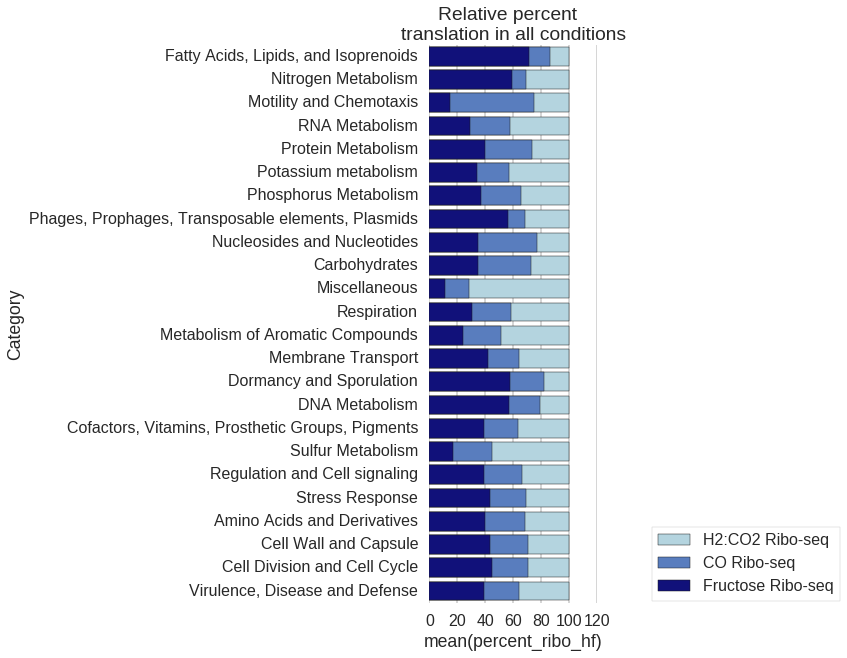

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context('poster')
f, (ax1) = plt.subplots(1, figsize=(3, 10))
sns.set_color_codes("muted")
sns.barplot(x="ribo_sum_row", y="Category", data=category_accross_rows,label="H2:CO2 Ribo-seq", color="lightblue", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="co_hf_ribo_row", y="Category", data=category_accross_rows, label="CO Ribo-seq", color="b", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="percent_ribo_hf", y="Category", data=category_accross_rows, label="Fructose Ribo-seq", color="darkblue", ax=ax1)
ax1.set_title("Relative percent  \ntranslation in all conditions")
sns.despine(left=True, bottom=True, ax=ax1)
ax1.legend(ncol=1, bbox_to_anchor=(2.5, 0.15), frameon=True,)

plt.show()

In [27]:
category_accross_rows=category_accross_rows.sort_values(by='ribo_sum_row', ascending = True)

ValueError: to_rgba: Invalid rgba arg "-1.16510788185"
to_rgb: Invalid rgb arg "-1.16510788185"
cannot convert argument to rgb sequence

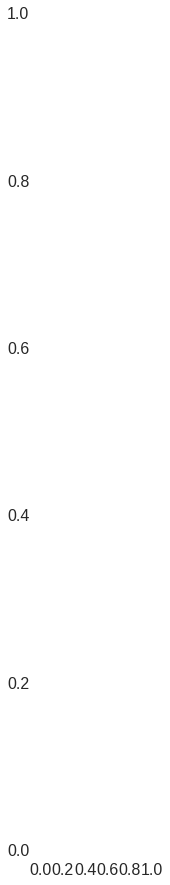

In [29]:
subcategory=np.arange(0,25,1)

hf_x = np.full(25, 1)
co_x = np.full(25, 2)
h2_x = np.full(25, 3)

sub_name=np.array(category_accross_rows.Category)

fig,ax =plt.subplots(figsize=(2,15))
sns.set_style('white')
sns.despine( bottom=True, left=True)
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x=hf_x, y=subcategory, \
                s=(category_accross_rows.percent_ribo_hf)*13,c=np.log2(category_accross_rows.ribo_sum_col),cmap=cm,\
                linewidth=1,alpha=1)

sc = ax.scatter(x=co_x, y=subcategory, \
                s=(category_accross_rows.percent_ribo_co)*13,c=np.log2(category_accross_rows.ribo_sum_col),cmap=cm,\
                linewidth=1,alpha=1)

sc = ax.scatter(x=h2_x, y=subcategory, \
                s=(category_accross_rows.percent_ribo_h2c)*13,c=np.log2(category_accross_rows.ribo_sum_col),cmap=cm,\
                linewidth=1,alpha=1)
ax.set_yticks(np.arange(0,25,1))
ax.set_yticklabels(sub_name, fontsize=15, fontweight='bold')
ax.set_ylim(-1,25)
ax.grid()
ax.xaxis.grid()
ax.tick_params(axis='y', pad=10)
position=fig.add_axes([2,.58 ,0.1,0.3])
cbar=fig.colorbar(sc,cax=position, use_gridspec=False)
cbar.ax.set_yticklabels([])
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RASTpercent_translation_per_subcat2.pdf', bbox_inches='tight')

In [18]:
category_accross_rows=category_accross_rows.sort_values(by='ribo_sum_col', ascending = False)

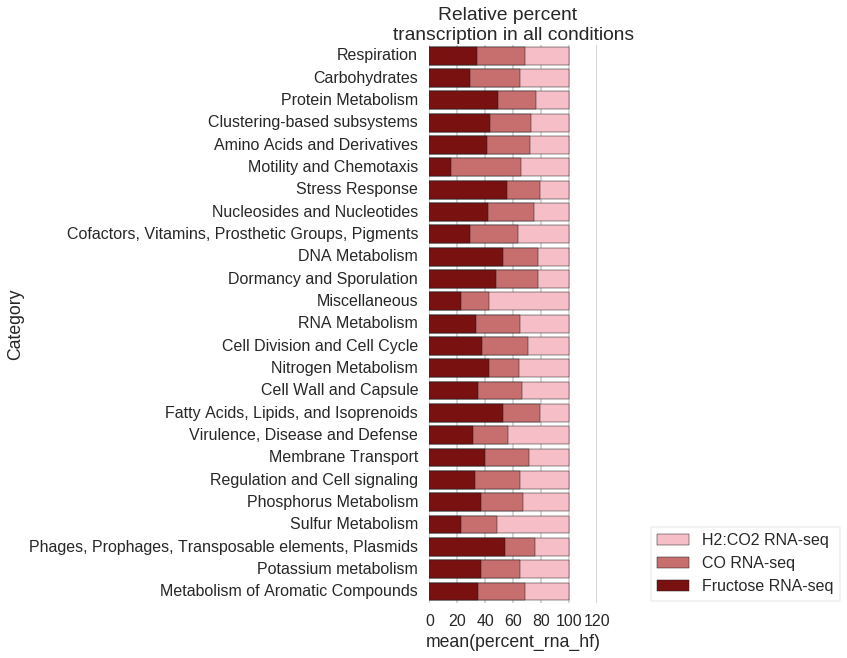

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_context('poster')
f, (ax1) = plt.subplots(1, figsize=(3, 10))
sns.set_color_codes("muted")
sns.barplot(x="rna_sum_row", y="Category", data=category_accross_rows,label="H2:CO2 RNA-seq", color="lightpink", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="co_hf_rna_row", y="Category", data=category_accross_rows, label="CO RNA-seq", color="r", ax=ax1)
sns.set_color_codes("muted")
sns.barplot(x="percent_rna_hf", y="Category", data=category_accross_rows, label="Fructose RNA-seq", color="darkred", ax=ax1)
ax1.set_title("Relative percent  \ntranscription in all conditions")
sns.despine(left=True, bottom=True, ax=ax1)
ax1.legend(ncol=1, bbox_to_anchor=(2.5, 0.15), frameon=True,)

plt.show()

In [20]:
category_accross_rows=category_accross_rows.sort_values(by='ribo_sum_col', ascending = True)

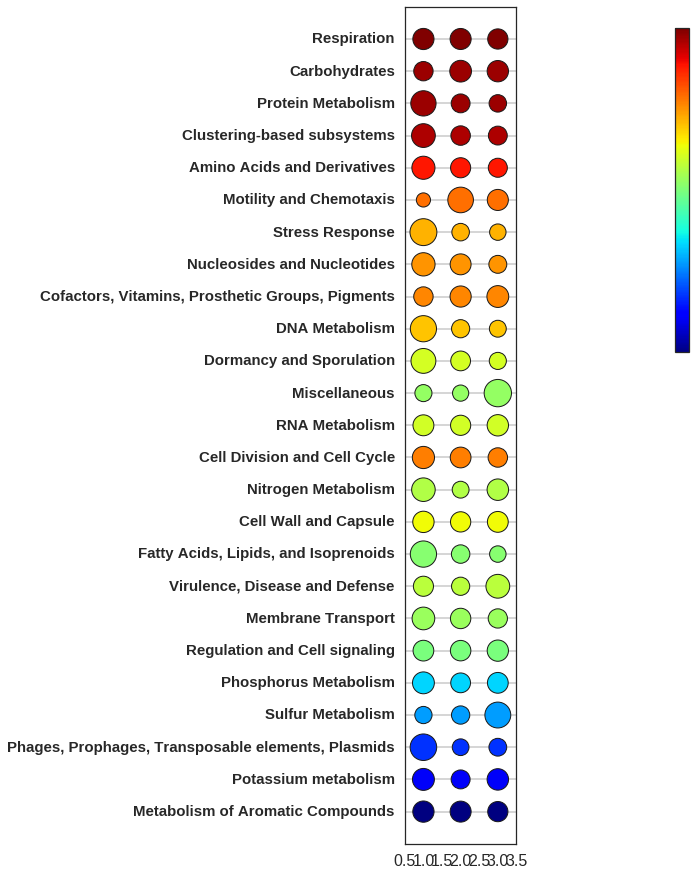

In [46]:
subcategory=np.arange(0,25,1)

hf_x = np.full(25, 1)
co_x = np.full(25, 2)
h2_x = np.full(25, 3)

sub_name=np.array(category_accross_rows.Category)

fig,ax =plt.subplots(figsize=(2,15))
sns.set_style('white')

cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x=hf_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_hf)*13,c=np.log2(category_accross_rows.rna_sum_col),cmap=cm,\
                linewidth=1,alpha=1)

sc = ax.scatter(x=co_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_co)*13,c=np.log2(category_accross_rows.rna_sum_col),cmap=cm,\
                linewidth=1,alpha=1)

sc = ax.scatter(x=h2_x, y=subcategory, \
                s=(category_accross_rows.percent_rna_h2c)*13,c=np.log2(category_accross_rows.rna_sum_col),cmap=cm,\
                linewidth=1,alpha=1)
ax.xaxis.grid()
ax.grid()
ax.set_yticks(np.arange(0,25,1))
ax.set_yticklabels(sub_name, fontsize=15, fontweight='bold')
ax.set_ylim(-1,25)
ax.tick_params( pad=10)
position=fig.add_axes([2,.58 ,0.1,0.3])
cbar=fig.colorbar(sc,cax=position)
cbar.ax.set_yticklabels([])
plt.savefig('/home/m/Dropbox/Clostridium_paper/figs/RASTpercent_transcription_per_subcat2.pdf', bbox_inches='tight')

In [53]:
rast[rast.Category=='Clustering-based subsystems']

,Unnamed: 0,Feature ID,locus,Category,Subcategory,Subsystem,Role,Organism A
0,0,peg.1,CLJU_RS00005,Clustering-based subsystems,Cell Division,Cell Division Subsystem including YidCD,Chromosomal replication initiator protein DnaA,peg.1
1,1,peg.2,CLJU_RS00010,Clustering-based subsystems,Cell Division,Cell Division Subsystem including YidCD,DNA polymerase III beta subunit (EC 2.7.7.7),peg.2
2,2,peg.3,CLJU_RS00015,Clustering-based subsystems,Hypothetical associated with RecF,Hypothetical Coupled to RecF,FIG002958: hypothetical protein,peg.3
3,3,peg.4,CLJU_RS00020,Clustering-based subsystems,Cell Division,Cell Division Subsystem including YidCD,DNA recombination and repair protein RecF,peg.4
4,4,peg.5,CLJU_RS00025,Clustering-based subsystems,no subcategory,DNA replication cluster 1,OrfX,peg.5
5,5,peg.6,CLJU_RS00030,Clustering-based subsystems,Cell Division,Cell Division Subsystem including YidCD,DNA gyrase subunit B (EC 5.99.1.3),peg.6
6,6,peg.7,CLJU_RS00035,Clustering-based subsystems,Cell Division,Cell Division Subsystem including YidCD,DNA gyrase subunit A (EC 5.99.1.3),peg.7
21,21,peg.75,CLJU_RS00395,Clustering-based subsystems,Phosphate metabolism,PhoR-PhoB two-component regulatory system,Phosphate regulon transcriptional regulatory p...,peg.75
33,33,peg.93,CLJU_RS00510,Clustering-based subsystems,Phosphate metabolism,PhoR-PhoB two-component regulatory system,Phosphate regulon transcriptional regulatory p...,peg.93
51,51,peg.119,CLJU_RS00680,Clustering-based subsystems,no subcategory,CBSS-393133.3.peg.2787,Thymidylate kinase (EC 2.7.4.9),peg.119


In [55]:
rast.groupby('Subcategory')['locus'].count()

Subcategory
ABC transporters                                                        21
Adhesion                                                                 1
Alanine, serine, and glycine                                            46
Arginine; urea cycle, polyamines                                        64
Aromatic amino acids and derivatives                                    25
Bacteriocins, ribosomally synthesized antibacterial peptides            14
Biotin                                                                   6
Branched-chain amino acids                                              16
Capsular and extracellular polysacchrides                               41
Cation transporters                                                     13
Cell Division                                                           18
Central carbohydrate metabolism                                         54
Checkpoint control                                                       5
Chemotaxis, r